In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm
from jax import grad
from jax import jit

In [2]:
# ---------- Base Classes ----------
class Disturbance:
    def __init__(self, d):
        self.d = d

    def sample(self, t, key):
        return jnp.zeros((self.d, 1))

class CostFunction:
    def evaluate(self, y, u):
        return 0.0

class Controller:
    def get_control(self, y):
        return jnp.zeros_like(y)

In [3]:
# ---------- Linear Dynamical System ----------
class LinearDynamicalSystem:
    def __init__(self, A, B, C, x0=None, disturbance=None):
        self.A = jnp.array(A)
        self.B = jnp.array(B)
        self.C = jnp.array(C)
        self.d = A.shape[0]
        self.n = B.shape[1]
        self.p = C.shape[0]
        self.x = jnp.zeros((self.d, 1)) if x0 is None else jnp.array(x0)
        self.t = 0
        self.disturbance = disturbance or Disturbance(self.d)
        self.history = {"x": [self.x], "u": [], "w": [], "y": []}

    def step(self, u_t, key):
        w_t = self.disturbance.sample(self.t, key)
        x_next = self.A @ self.x + self.B @ u_t + w_t
        y_t = self.C @ self.x
        self.history["x"].append(x_next)
        self.history["u"].append(u_t)
        self.history["w"].append(w_t)
        self.history["y"].append(y_t)
        self.x = x_next
        self.t += 1
        return y_t

In [4]:
# ---------- Gaussian Disturbance ----------
class GaussianDisturbance(Disturbance):
    def __init__(self, d, std=0.5):
        super().__init__(d)
        self.std = std

    def sample(self, t, key):
        return jax.random.normal(key, (self.d, 1)) * self.std

In [5]:
# ---------- Cost Function ----------
class QuadraticCost(CostFunction):
    def __init__(self, Q, R):
        self.Q = jnp.array(Q)      # cost on output y
        self.R = jnp.array(R)      # cost on control u
        self.p = Q.shape[0]
        self.n = R.shape[0]

    def evaluate(self, y, u):
        assert y.shape == (self.p, 1), f"Expected y shape ({self.p}, 1), got {y.shape}"
        assert u.shape == (self.n, 1), f"Expected u shape ({self.n}, 1), got {u.shape}"
        return jnp.sum(y.T @ self.Q @ y + u.T @ self.R @ u)

In [6]:
class GPCController(Controller):
    def __init__(self, A, B, C, cost: CostFunction, R_M: float, key: jax.random.key, init_scale: float = 1.0, m: int=10, lr: float=0.005, decay: bool=True):
        self.A = jnp.array(A)
        self.B = jnp.array(B)
        self.C = jnp.array(C)
        self.d = self.A.shape[0]
        self.n = self.B.shape[1]
        self.p = self.C.shape[0]

        self.cost = cost
        self.lr = lr
        self.decay = decay
        self.R_M = R_M

        self.m = m

        self.t = 0
        self.M = init_scale*jax.random.normal(key, shape=(self.m, self.n, self.p))

        self.z = jnp.zeros((self.d, 1))
        self.ynat_history = jnp.zeros((2*self.m, self.p, 1))

        def last_m_ynats():
            return jax.lax.dynamic_slice(self.ynat_history, (self.m, 0, 0), (self.m, self.p, 1))

        self.last_m_ynats = last_m_ynats

        def policy_loss(M, ynats):
            def action(k):
                window = jax.lax.dynamic_slice(ynats, (k, 0, 0), (self.m, self.p, 1))
                contribs = jnp.einsum("mnp,mp1->mn1", M, window)
                return jnp.sum(contribs, axis=0)

            def evolve(delta, h):
                return self.A @ delta + self.B @ action(h), None

            final_delta, _ = jax.lax.scan(evolve, jnp.zeros((self.d, 1)), jnp.arange(self.m))
            final_y = self.C @ final_delta + ynats[-1]
            return self.cost.evaluate(final_y, action(self.m))

        self.policy_loss = policy_loss
        self.grad = jit(grad(policy_loss, (0)))

    def get_control(self, y):
        u = self.get_action(y)
        self.update(y, u)
        return u

    def update(self, y, u):
        self.z = self.A @ self.z + self.B @ u
        y_nat = y - self.C @ self.z
        self.ynat_history = self.ynat_history.at[0].set(y_nat)
        self.ynat_history = jnp.roll(self.ynat_history, -1, axis=0)

        delta_M = self.grad(self.M, self.ynat_history)
        lr = self.lr * (1 / (self.t + 1) if self.decay else 1)
        self.M -= lr * delta_M

        norm = jnp.linalg.norm(self.M)
        scale = jnp.minimum(1.0, self.R_M / (norm + 1e-8))
        self.M = scale*self.M

        self.t += 1

    def get_action(self, y):
        window = self.last_m_ynats()
        contribs = jnp.einsum('mnp,mp1->mn1', self.M, window)
        return jnp.sum(contribs, axis=0)

100%|██████████| 50/50 [05:53<00:00,  7.07s/it]

Removed 40 unstable trial(s) out of 50


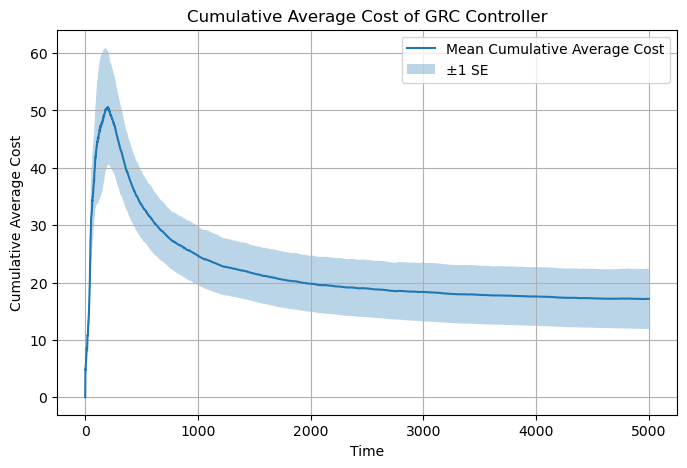

In [7]:
# Parameters
d, n, p = 4, 2, 3
dist_std = 0.5
param_init_scale = 0.1
m=10
learning_rate = 1e-4
R_M = 10.0
T = 5000
num_trials = 50

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    gpc = GPCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, key=subkey4, init_scale=param_init_scale, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = gpc.get_control(y)
        c = cost_fn.evaluate(y, u)
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
threshold = 1e6
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost = np.mean(average_until_now, axis=0)
stderr_avg_cost = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mean_avg_cost, label="Mean Cumulative Average Cost")
plt.fill_between(np.arange(T), mean_avg_cost - stderr_avg_cost, mean_avg_cost + stderr_avg_cost,
                 alpha=0.3, label="±1 SE")
plt.xlabel("Time")
plt.ylabel("Cumulative Average Cost")
plt.title("Cumulative Average Cost of GRC Controller")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
class SFCController(Controller):
    def __init__(self, A, B, C, cost: CostFunction, R_M: float, gamma: float, key: jax.random.key, init_scale: float = 1.0, h: int=10, m: int=30, lr: float=0.005, decay: bool=True):
        self.A = jnp.array(A)
        self.B = jnp.array(B)
        self.C = jnp.array(C)
        self.d = self.A.shape[0]
        self.n = self.B.shape[1]
        self.p = self.C.shape[0]

        self.cost = cost
        self.lr = lr
        self.decay = decay
        self.R_M = R_M

        self.m = m
        self.h = h

        self.t = 0
        subkey_1, subkey2 = jax.random.split(key)
        self.M = init_scale*jax.random.normal(subkey1, shape=(self.h, self.n, self.p))
        self.M_0 = init_scale*jax.random.normal(subkey2, shape=(self.n, self.p))

        self.z = jnp.zeros((self.d, 1))
        self.ynat_history = jnp.zeros((2*self.m+1, self.p, 1))

        # Construct Filters
        indices = np.arange(1, self.m + 1)
        I, J = np.meshgrid(indices, indices, indexing='ij')
        H_matrix = ((1 - gamma) ** (I + J - 1)) / (I + J - 1)

        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(H_matrix)

        # Get top H eigenvalues and eigenvectors
        top_eigvals = eigvals[-self.h:]         # shape: (h,)
        top_eigvecs = eigvecs[:, -self.h:]      # shape: (m, h)

        # Scale each eigenvector by sigma_i^{1/4}
        scaling = top_eigvals**0.25        # shape: (h,)
        self.filters = jnp.flip((scaling[:, None] * top_eigvecs.T), axis=1)  # shape: (h, m)

        def last_m_ynats():
            return jax.lax.dynamic_slice(self.ynat_history, (self.m, 0, 0), (self.m, self.p, 1))

        self.last_m_ynats = last_m_ynats

        def last_ynat():
            return jnp.squeeze(jax.lax.dynamic_slice(self.ynat_history, (2*self.m, 0, 0), (1, self.p, 1)), axis=0)

        self.last_ynat = last_ynat

        def policy_loss(M_0, M, ynats):
            def action(k):
                window = jax.lax.dynamic_slice(ynats, (k, 0, 0), (self.m, self.p, 1))
                last_ynat = jnp.squeeze(jax.lax.dynamic_slice(ynats, (k+self.m, 0, 0), (1, self.p, 1)), axis=0)
                proj = jnp.einsum("hm,mp1->hp1", self.filters, window)  # (h, p, 1)
                spectral_term = jnp.einsum("hnp,hp1->n1", M, proj)
                return M_0 @ last_ynat + spectral_term

            def evolve(delta, h):
                return self.A @ delta + self.B @ action(h), None

            final_delta, _ = jax.lax.scan(evolve, jnp.zeros((self.d, 1)), jnp.arange(self.m))
            final_y = self.C @ final_delta + ynats[-1]
            return self.cost.evaluate(final_y, action(self.m))

        self.policy_loss = policy_loss
        self.grad = jit(grad(policy_loss, (0, 1)))

    def get_control(self, y):
        u = self.get_action(y)
        self.update(y, u)
        return u

    def update(self, y, u):
        self.z = self.A @ self.z + self.B @ u
        y_nat = y - self.C @ self.z
        self.ynat_history = self.ynat_history.at[0].set(y_nat)
        self.ynat_history = jnp.roll(self.ynat_history, -1, axis=0)

        delta_M_0, delta_M = self.grad(self.M_0, self.M, self.ynat_history)
        lr = self.lr * (1 / (self.t + 1) if self.decay else 1)
        self.M_0 -= lr*delta_M_0
        self.M -= lr * delta_M

        norm = jnp.sqrt(jnp.sum(self.M ** 2) + jnp.sum(self.M_0 ** 2))
        scale = jnp.minimum(1.0, self.R_M / (norm + 1e-8))
        self.M_0 = scale*self.M_0
        self.M = scale*self.M

        self.t += 1

    def get_action(self, y):
        window = self.last_m_ynats()
        last_ynat = self.last_ynat()
        proj = jnp.einsum("hm,mp1->hp1", self.filters, window)  # (h, p, 1)
        spectral_term = jnp.einsum("hnp,hp1->n1", self.M, proj)
        return self.M_0 @ last_ynat + spectral_term

100%|██████████| 50/50 [09:17<00:00, 11.14s/it]

Removed 27 unstable trial(s) out of 50


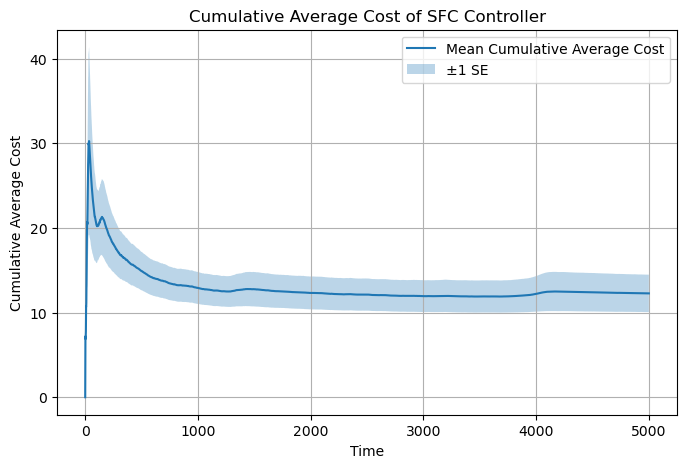

In [9]:
# Parameters
d, n, p = 4, 2, 3
dist_std = 0.5
param_init_scale = 0.1
m=30
h=10
learning_rate = 1e-4
R_M = 10.0
gamma = 0.2
T = 5000
num_trials = 50

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    sfc = SFCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, gamma=gamma, key=subkey4, init_scale=param_init_scale, h=h, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = sfc.get_control(y)
        c = cost_fn.evaluate(y, u)
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
threshold = 1e6
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost = np.mean(average_until_now, axis=0)
stderr_avg_cost = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mean_avg_cost, label="Mean Cumulative Average Cost")
plt.fill_between(np.arange(T), mean_avg_cost - stderr_avg_cost, mean_avg_cost + stderr_avg_cost,
                 alpha=0.3, label="±1 SE")
plt.xlabel("Time")
plt.ylabel("Cumulative Average Cost")
plt.title("Cumulative Average Cost of SFC Controller")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
class DSCController(Controller):
    def __init__(self, A, B, C, cost: CostFunction, R_M: float, gamma: float, key: jax.random.key, init_scale: float = 1.0, h: int=10, m: int=30, lr: float=0.005, decay: bool=True):
        self.A = jnp.array(A)
        self.B = jnp.array(B)
        self.C = jnp.array(C)
        self.d = self.A.shape[0]
        self.n = self.B.shape[1]
        self.p = self.C.shape[0]

        self.cost = cost
        self.lr = lr
        self.decay = decay
        self.R_M = R_M

        self.m = m
        self.h = h

        self.t = 0
        subkey_1, subkey2, subkey3, subkey4 = jax.random.split(key, 4)
        self.M_0 = init_scale*jax.random.normal(subkey1, shape=(self.n, self.p))
        self.M_1 = init_scale*jax.random.normal(subkey2, shape=(self.h, self.n, self.p))
        self.M_2 = init_scale*jax.random.normal(subkey3, shape=(self.h, self.n, self.p))
        self.M_3 = init_scale*jax.random.normal(subkey3, shape=(self.h, self.h, self.n, self.p))

        self.z = jnp.zeros((self.d, 1))
        self.ynat_history = jnp.zeros((3*self.m+1, self.p, 1))

        # Construct Filters
        indices = np.arange(1, self.m + 1)
        I, J = np.meshgrid(indices, indices, indexing='ij')
        H_matrix = ((1 - gamma) ** (I + J - 1)) / (I + J - 1)

        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(H_matrix)

        # Get top H eigenvalues and eigenvectors
        top_eigvals = eigvals[-self.h:]         # shape: (h,)
        top_eigvecs = eigvecs[:, -self.h:]      # shape: (m, h)

        # Scale each eigenvector by sigma_i^{1/4}
        scaling = top_eigvals**0.25        # shape: (h,)
        self.filters = jnp.flip((scaling[:, None] * top_eigvecs.T), axis=1)  # shape: (h, m)

        def last_ynat():
            return jnp.squeeze(jax.lax.dynamic_slice(self.ynat_history, (3*self.m, 0, 0), (1, self.p, 1)), axis=0)

        self.last_ynat = last_ynat

        # def prev_m_ynats():
        #     return jax.lax.dynamic_slice(self.ynat_history, (2*self.m, 0, 0), (self.m, self.p, 1))

        # self.prev_m_ynats = prev_m_ynats

        # def last_m_ynats():
        #     return jax.lax.dynamic_slice(self.ynat_history, (2*self.m+1, 0, 0), (self.m, self.p, 1))

        # self.last_m_ynats = last_m_ynats

        def slice_window(start):
            return jax.lax.dynamic_slice(self.ynat_history, (start, 0, 0), (self.m, p, 1))

        self.slice_window = slice_window

        def last_ynat_matrix():
            starts = jnp.arange(self.m+1, 2*self.m+1)
            return jax.vmap(self.slice_window)(starts)

        self.last_ynat_matrix = last_ynat_matrix

        def policy_loss(M_0, M_1, M_2, M_3, ynat_history):
            def action(k):
                last_ynat = jnp.squeeze(jax.lax.dynamic_slice(ynat_history, (k+2*self.m, 0, 0), (1, self.p, 1)), axis=0)

                prev_m_ynats = jax.lax.dynamic_slice(ynat_history, (k+self.m, 0, 0), (self.m, self.p, 1))
                proj = jnp.einsum("hm,mp1->hp1", self.filters, prev_m_ynats)  # (h, p, 1)
                lin_spectral_term_1 = jnp.einsum("hnp,hp1->n1", M_1, proj)

                last_m_ynats = jax.lax.dynamic_slice(ynat_history, (k+self.m+1, 0, 0), (self.m, self.p, 1))
                proj = jnp.einsum("hm,mp1->hp1", self.filters, last_m_ynats)  # (h, p, 1)
                lin_spectral_term_2 = jnp.einsum("hnp,hp1->n1", M_2, proj)

                def get_last_ynat_matrix(ynat_history, k, m, p):
                    offsets = jnp.arange(m)

                    def extract_window(i):
                        start = k + 1 + i
                        return jax.lax.dynamic_slice(ynat_history, (start, 0, 0), (m, p, 1))  # shape (m, p, 1)

                    return jax.vmap(extract_window)(offsets)

                last_ynat_matrix = get_last_ynat_matrix(ynat_history, k, self.m, self.p)
                temp = jnp.einsum("hi,imp1->hmp1", self.filters, last_ynat_matrix)
                filtered = jnp.einsum("jm,hmp1->hjp1", self.filters, temp)
                contrib = jnp.einsum("hjnp,hjp1->hjn1", M_3, filtered)

                return M_0 @ last_ynat + lin_spectral_term_1 + lin_spectral_term_2 + jnp.sum(contrib, axis=(0, 1))

            def evolve(delta, h):
                return self.A @ delta + self.B @ action(h), None

            final_delta, _ = jax.lax.scan(evolve, jnp.zeros((self.d, 1)), jnp.arange(self.m))
            final_y = self.C @ final_delta + ynat_history[-1]
            return self.cost.evaluate(final_y, action(self.m))

        self.policy_loss = policy_loss
        self.grad = jit(grad(policy_loss, (0, 1, 2, 3)))

    def get_control(self, y):
        u = self.get_action(y)
        self.update(y, u)
        return u

    def update(self, y, u):
        self.z = self.A @ self.z + self.B @ u
        y_nat = y - self.C @ self.z
        self.ynat_history = self.ynat_history.at[0].set(y_nat)
        self.ynat_history = jnp.roll(self.ynat_history, -1, axis=0)

        delta_M_0, delta_M_1, delta_M_2, delta_M_3 = self.grad(self.M_0, self.M_1, self.M_2, self.M_3, self.ynat_history)
        lr = self.lr * (1 / (self.t + 1) if self.decay else 1)
        self.M_0 -= lr*delta_M_0
        self.M_1 -= lr * delta_M_1
        self.M_2 -= lr * delta_M_2
        self.M_3 -= lr * delta_M_3

        norm = jnp.sqrt(jnp.sum(self.M_0 ** 2) + jnp.sum(self.M_1 ** 2) + jnp.sum(self.M_2 ** 2) + jnp.sum(self.M_3 ** 2))
        scale = jnp.minimum(1.0, self.R_M / (norm + 1e-8))
        self.M_0 = scale*self.M_0
        self.M_1 = scale*self.M_1
        self.M_2 = scale*self.M_2
        self.M_3 = scale*self.M_3

        self.t += 1

    def get_action(self, y):
        last_ynat = self.last_ynat()

        prev_m_ynats = self.slice_window(2*self.m)
        proj = jnp.einsum("hm,mp1->hp1", self.filters, prev_m_ynats)  # (h, p, 1)
        lin_spectral_term_1 = jnp.einsum("hnp,hp1->n1", self.M_1, proj)

        last_m_ynats = self.slice_window(2*self.m+1)
        proj = jnp.einsum("hm,mp1->hp1", self.filters, last_m_ynats)  # (h, p, 1)
        lin_spectral_term_2 = jnp.einsum("hnp,hp1->n1", self.M_2, proj)

        last_ynat_matrix = self.last_ynat_matrix()
        temp = jnp.einsum("hi,imp1->hmp1", self.filters, last_ynat_matrix)
        filtered = jnp.einsum("jm,hmp1->hjp1", self.filters, temp)
        contrib = jnp.einsum("hjnp,hjp1->hjn1", self.M_3, filtered)

        return self.M_0 @ last_ynat + lin_spectral_term_1 + lin_spectral_term_2 + jnp.sum(contrib, axis=(0, 1))

100%|██████████| 10/10 [05:45<00:00, 34.58s/it]

Removed 0 unstable trial(s) out of 10


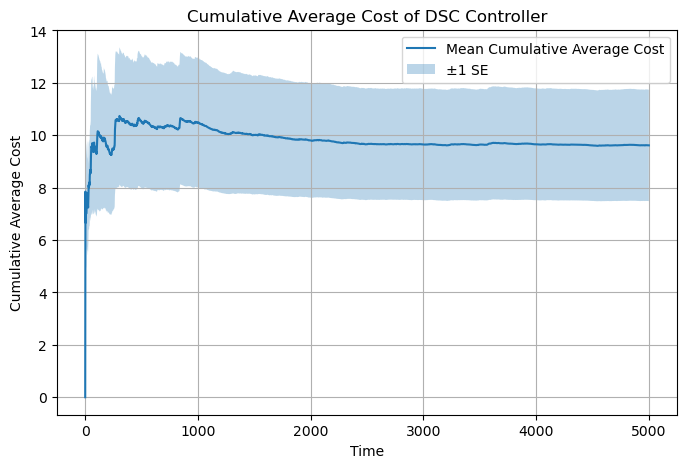

In [11]:
# Parameters
d, n, p = 4, 2, 3
dist_std = 0.5
param_init_scale = 0.1
m=30
h=10
learning_rate = 1e-4
R_M = 0.1
gamma = 0.2
T = 5000
num_trials = 10
threshold = 1e6

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    dsc = DSCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, gamma=gamma, key=subkey4, init_scale=param_init_scale, h=h, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = dsc.get_control(y)
        c = cost_fn.evaluate(y, u)
        if c > threshold:
          print("cost exceeded threshold")
          print(y, u, c)
          print(dsc.M_0, dsc.M_1, dsc.M_2, dsc.M_3)
          print(dsc.ynat_history)
          break
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost_dsc = np.mean(average_until_now, axis=0)
stderr_avg_cost_dsc = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mean_avg_cost_dsc, label="Mean Cumulative Average Cost")
plt.fill_between(np.arange(T), mean_avg_cost_dsc - stderr_avg_cost_dsc, mean_avg_cost_dsc + stderr_avg_cost_dsc,
                 alpha=0.3, label="±1 SE")
plt.xlabel("Time")
plt.ylabel("Cumulative Average Cost")
plt.title("Cumulative Average Cost of DSC Controller")
plt.legend()
plt.grid(True)
plt.show()

Running GRC


100%|██████████| 25/25 [03:10<00:00,  7.63s/it]


Removed 1 unstable trial(s) out of 25
Running SFC


100%|██████████| 25/25 [04:41<00:00, 11.24s/it]


Removed 0 unstable trial(s) out of 25
Running DSC


100%|██████████| 25/25 [13:53<00:00, 33.33s/it]


Removed 0 unstable trial(s) out of 25


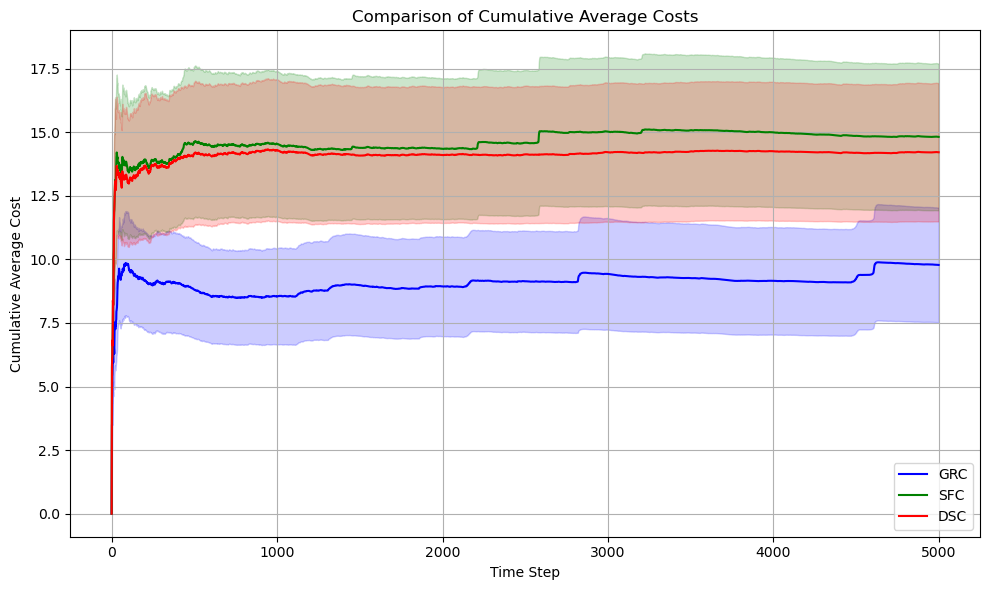

In [12]:
print("Running GRC")
# Parameters
d, n, p = 25, 1, 1
dist_std = 0.5
param_init_scale = 0.1
m=10
learning_rate = 1e-4
R_M = 0.1
T = 5000
num_trials = 25

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    gpc = GPCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, key=subkey4, init_scale=param_init_scale, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = gpc.get_control(y)
        c = cost_fn.evaluate(y, u)
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
threshold = 1e6
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost_grc = np.mean(average_until_now, axis=0)
stderr_avg_cost_grc = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)


print("Running SFC")
# Parameters
d, n, p = 4, 2, 3
dist_std = 0.5
param_init_scale = 0.1
m=30
h=10
learning_rate = 1e-4
R_M = 0.1
gamma = 0.2
T = 5000
num_trials = 25

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    sfc = SFCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, gamma=gamma, key=subkey4, init_scale=param_init_scale, h=h, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = sfc.get_control(y)
        c = cost_fn.evaluate(y, u)
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
threshold = 1e6
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost_sfc = np.mean(average_until_now, axis=0)
stderr_avg_cost_sfc = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)


print("Running DSC")
# Parameters
d, n, p = 4, 2, 3
dist_std = 0.5
param_init_scale = 0.1
m=30
h=10
learning_rate = 1e-4
R_M = 0.001
gamma = 0.2
T = 5000
num_trials = 25
threshold = 1e6

all_costs = np.zeros((num_trials, T))

for trial in tqdm(range(num_trials)):
    key = jax.random.PRNGKey(trial)

    # Generate stable A, random B, C
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)
    eigvals = jax.random.uniform(subkey1, (d,), minval=0.3, maxval=0.7)
    A = jnp.diag(eigvals)

    key, *subkeys = jax.random.split(key, 4)
    B = jax.random.normal(subkeys[0], (d, n))
    C = jax.random.normal(subkeys[1], (p, d))

    # Random PSD cost matrices
    M_Q = jax.random.normal(subkey2, (p, p))
    M_R = jax.random.normal(subkey3, (n, n))

    Q = M_Q.T @ M_Q
    R = M_R.T @ M_R

    # Assume K is defined globally or externally
    dist = GaussianDisturbance(d, std=dist_std)
    lds = LinearDynamicalSystem(A, B, C, disturbance=dist)
    cost_fn = QuadraticCost(Q, R)
    dsc = DSCController(A=A, B=B, C=C, cost=cost_fn, R_M=R_M, gamma=gamma, key=subkey4, init_scale=param_init_scale, h=h, m=m, lr=learning_rate, decay=True)

    costs = []
    for t in range(T):
        key, subkey = jax.random.split(key)
        y = lds.step(lds.history["u"][-1] if lds.history["u"] else jnp.zeros((n, 1)), subkey)
        u = dsc.get_control(y)
        c = cost_fn.evaluate(y, u)
        # if c > threshold:
        #   print("cost exceeded threshold")
        #   print(y, u, c)
        #   print(dsc.M_0, dsc.M_1, dsc.M_2, dsc.M_3)
        #   print(dsc.ynat_history)
        #   break
        costs.append(c)

    all_costs[trial] = costs

# Compute cumulative costs
cumulative_costs = np.cumsum(all_costs, axis=1)

# Identify stable trials (e.g., final cumulative cost not exploding)
stable_mask = cumulative_costs[:, -1] < threshold
num_removed = np.sum(~stable_mask)
print(f"Removed {num_removed} unstable trial(s) out of {num_trials}")

# Keep only stable trials
cumulative_costs = cumulative_costs[stable_mask]
all_costs = all_costs[stable_mask]
num_stable_trials = cumulative_costs.shape[0]

# Compute average cost over time
average_until_now = cumulative_costs / (np.arange(1, T + 1)[None, :])
mean_avg_cost_dsc = np.mean(average_until_now, axis=0)
stderr_avg_cost_dsc = np.std(average_until_now, axis=0) / np.sqrt(num_stable_trials)

plt.figure(figsize=(10, 6))

# GRC
plt.plot(mean_avg_cost_grc, label="GRC", color="blue")
plt.fill_between(np.arange(T),
                 mean_avg_cost_grc - stderr_avg_cost_grc,
                 mean_avg_cost_grc + stderr_avg_cost_grc,
                 alpha=0.2, color="blue")

# SFC
plt.plot(mean_avg_cost_sfc, label="SFC", color="green")
plt.fill_between(np.arange(T),
                 mean_avg_cost_sfc - stderr_avg_cost_sfc,
                 mean_avg_cost_sfc + stderr_avg_cost_sfc,
                 alpha=0.2, color="green")

# DSC
plt.plot(mean_avg_cost_dsc, label="DSC", color="red")
plt.fill_between(np.arange(T),
                 mean_avg_cost_dsc - stderr_avg_cost_dsc,
                 mean_avg_cost_dsc + stderr_avg_cost_dsc,
                 alpha=0.2, color="red")

# Labels and legend
plt.xlabel("Time Step")
plt.ylabel("Cumulative Average Cost")
plt.title("Comparison of Cumulative Average Costs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
